In [84]:
# importing libraries
import pandas as pd
import numpy as np
import plot
import scipy.stats as scs
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from six import StringIO
from sklearn.tree import export_graphviz
from sklearn import metrics
from IPython.display import Image
from urllib.parse import urlparse
import mlflow
import mlflow
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pydotplus
import warnings
import scipy
import scipy.stats as stat
import pickle
import helper

In [90]:
warnings.filterwarnings('ignore')
pd.set_option('max_column', None)
pd.set_option('display.float_format',lambda x:'%5f'%x)

<h1>Task 2: A/B testing with Machine Learning<h1>

In [28]:
File_Path = "../data/AdSmartABdata.csv"

In [29]:
data = pd.read_csv(File_Path)
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [30]:
# droping the users that did not answer
def drop_no_responds(df):
    cleaned_df = df.query("not (yes == 0 & no == 0)")
    return cleaned_df



<h3>Data Transformation<h3>

In [32]:
cleaneddata = drop_no_responds(data)
cleaneddata['aware'] = cleaneddata['yes'].map(lambda x: x==1)
cleaneddata = cleaneddata.drop(columns = ['yes', 'no', 'auction_id'], axis=1)
cleaneddata.head()

,experiment,date,hour,device_make,platform_os,browser,aware
2,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,False
16,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,True
20,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,False
23,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,True
27,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,False


In [33]:
def save_cleaned_data():
    CLEANED_CSV_PATH = "../Data/clean_data.csv"
    pd.save_csv(cleaneddata, CLEANED_CSV_PATH)

Data preparation

In [34]:
# label encoding
def encode_labels(df):
    date_encoder = preprocessing.LabelEncoder()
    device_encoder = preprocessing.LabelEncoder()
    browser_encoder = preprocessing.LabelEncoder()
    experiment_encoder = preprocessing.LabelEncoder()
    aware_encoder = preprocessing.LabelEncoder()
    
    df['date'] = date_encoder.fit_transform(df['date'])
    df['device_make'] = device_encoder.fit_transform(df['device_make'])
    df['browser'] = browser_encoder.fit_transform(df['browser'])
    df['experiment'] = experiment_encoder.fit_transform(df['experiment'])
    df['aware'] = aware_encoder.fit_transform(df['aware'])

<h2> Splitting data by platform and browser<h2>

In [35]:

def feature_data(cleaned_df):
    
    browser_df = cleaned_df[['experiment', 'hour', 'date', 'device_make', 'browser', 'aware']]
    platfrom_df = cleaned_df[['experiment', 'hour', 'date', 'device_make', 'platform_os', 'aware']]

    return browser_df, platfrom_df

In [36]:
def save_encoded_df():
    
    browser_df, platfrom_df = feature_data(encoded_df)
    pd.save_csv(browser_df, "../Data/clean_data.csv")
    pd.save_csv(platfrom_df, "../Data/clean_data.csv")

<h2> Model building <h2>

In [37]:
# loss Function
def loss_function(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    return rmse

In [38]:
# Decision Tree Model
class DecisionTreesModel:
    
    def __init__(self, X_train, X_test, y_train, y_test, max_depth=5):
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.clf = DecisionTreeClassifier(max_depth=4)
    def train(self, folds=1):
        
        kf = KFold(n_splits = folds)
        
        iterator = kf.split(self.X_train)
        
        loss_arr = []
        acc_arr = []
        for i in range(folds):
            train_index, valid_index = next(iterator)
            
            X_train, y_train = self.X_train.iloc[train_index], self.y_train.iloc[train_index]
            X_valid, y_valid = self.X_train.iloc[valid_index], self.y_train.iloc[valid_index]
                        
            self.clf = self.clf.fit(X_train, y_train)
            
            vali_pred = self.clf.predict(X_valid)
            
            accuracy = self.calculate_score(y_valid
                                              , vali_pred)
            
            loss = loss_function(y_valid, vali_pred)
            
            self.__printAccuracy(accuracy, i, label="Validation")
            self.__printLoss(loss, i, label="Validation")
            print()
            
            acc_arr.append(accuracy)
            loss_arr.append(loss)

            
        return self.clf, acc_arr, loss_arr
    def test(self):
        
        y_pred = self.clf.predict(self.X_test)
        
        accuracy = self.calculate_score(y_pred, self.y_test)
        self.__printAccuracy(accuracy, label="Test")
        
        report = self.report(y_pred, self.y_test)
        matrix = self.confusion_matrix(y_pred, self.y_test)
        
        loss = loss_function(self.y_test, y_pred)
        
        return accuracy, loss,  report, matrix
    def get_feature_importance(self):
        importance = self.clf.feature_importances_
        fi_df = pd.DataFrame()
        
        fi_df['feature'] = self.X_train.columns.to_list()
        fi_df['feature_importances'] = importance
        
        return fi_df
    
    def __printAccuracy(self, acc, step=1, label=""):
        print(f"step {step}: {label} Accuracy of DecisionTreesModel is: {acc:.3f}")
    
    def __printLoss(self, loss, step=1, label=""):
        print(f"step {step}: {label} Loss of DecisionTreesModel is: {loss:.3f}")
    
    def calculate_score(self, pred, actual):
        return metrics.accuracy_score(actual, pred)
    
    def report(self, pred, actual):
        print("Test Metrics")
        print("================")
        print(metrics.classification_report(pred, actual))
        return metrics.classification_report(pred, actual)
    
    def confusion_matrix(self, pred, actual):
        ax=sns.heatmap(pd.DataFrame(metrics.confusion_matrix(pred, actual)))
        plt.title('Confusion matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        return metrics.confusion_matrix(pred, actual)
    

In [39]:
# encoding the data
encode_labels(cleaneddata)

In [40]:
platform_df = cleaneddata.drop(['browser'], axis=1)
browser_df = cleaneddata.drop(['platform_os'], axis=1)


In [41]:
print("1. Encoded Dataframe containing the the platfrom column")
platform_df.head()

1. Encoded Dataframe containing the the platfrom column


,experiment,date,hour,device_make,platform_os,aware
2,1,2,2,4,6,0
16,1,1,16,13,6,1
20,1,3,8,13,6,0
23,0,5,4,43,6,1
27,0,0,15,13,6,0


In [42]:
print("1. Encoded Dataframe containing the the browser column")
browser_df.head()

1. Encoded Dataframe containing the the browser column


,experiment,date,hour,device_make,browser,aware
2,1,2,2,4,2,0
16,1,1,16,13,1,1
20,1,3,8,13,1,0
23,0,5,4,43,4,1
27,0,0,15,13,1,0


<h2>1 Model training using Decision Tree using browser dataframe<h2>

Train Test Split

In [43]:

# feature_cols = ['experiment', 'hour', 'date', 'device_make', 'platform_os',  'browser']
feature_cols = ['experiment', 'hour', 'date', 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

Model Training Using DecisionTreesModel

In [44]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

clf, acc_arr, loss_arr = decisionTreesModel.train(5)


step 0: Validation Accuracy of DecisionTreesModel is: 0.571
step 0: Validation Loss of DecisionTreesModel is: 0.655

step 1: Validation Accuracy of DecisionTreesModel is: 0.536
step 1: Validation Loss of DecisionTreesModel is: 0.681

step 2: Validation Accuracy of DecisionTreesModel is: 0.558
step 2: Validation Loss of DecisionTreesModel is: 0.665

step 3: Validation Accuracy of DecisionTreesModel is: 0.516
step 3: Validation Loss of DecisionTreesModel is: 0.696

step 4: Validation Accuracy of DecisionTreesModel is: 0.565
step 4: Validation Loss of DecisionTreesModel is: 0.660




Evaluating our model

step 1: Test Accuracy of DecisionTreesModel is: 0.544
Test Metrics
              precision    recall  f1-score   support

           0       0.95      0.53      0.69       116
           1       0.10      0.67      0.17         9

    accuracy                           0.54       125
   macro avg       0.53      0.60      0.43       125
weighted avg       0.89      0.54      0.65       125

Loss on test data is: 0.675



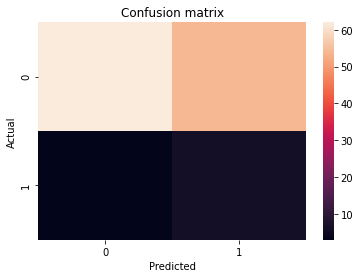

In [45]:
test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

Calculating feature importance

In [46]:
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.000000
1,hour,0.401460
2,date,0.054408
3,device_make,0.336032
4,browser,0.208099


Our experiment feature has feature importances of 0. The'experiment' feature is not important for awareness in the Decision Tree Model. The most important feature for awareness in the  Decision Tree Model is hour which has feature importance of 0.45 followed by device_make of 0.33. But this is a result of a decision tree model with max-depth of 4. if we increase the max-depth, we might observe a differnt result in feature importance.

### Visualzing feature importance for browser data

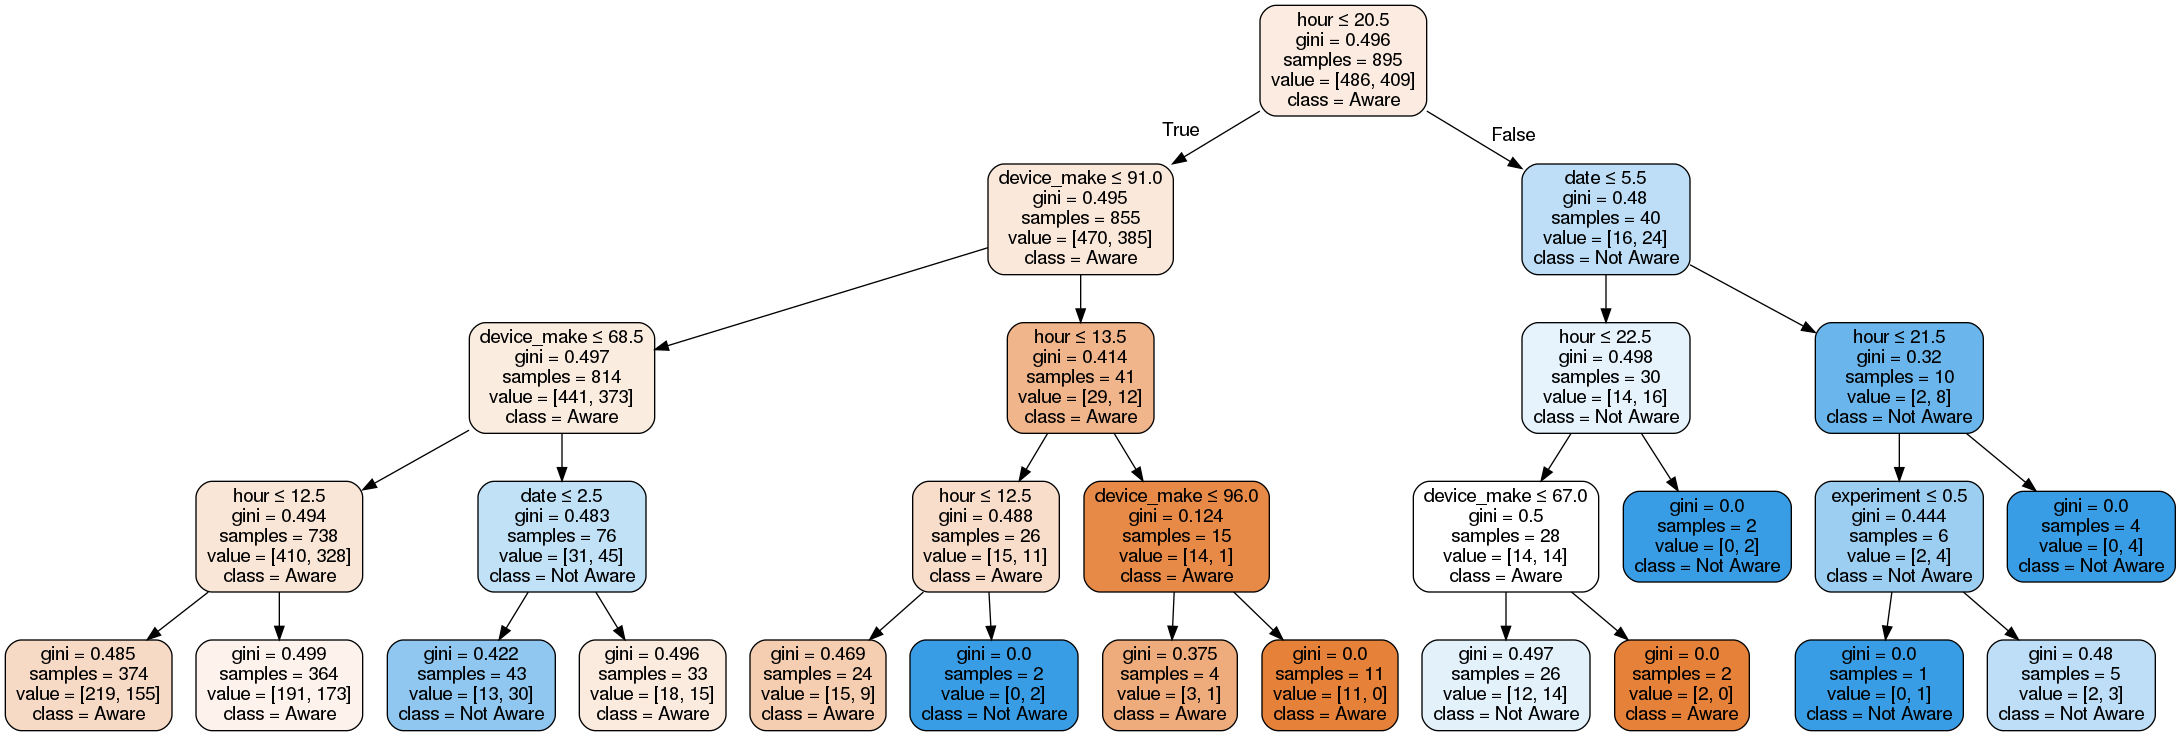

In [52]:
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')

Image(graph.create_png())

<h2>The experiment feature is found on the 4th level depth of the Decision Tree. From this we can conclude that the'experiment' feature is not the important factor for the target variable.But the most important feature to contribute for awareness of AD in DEsision Tree model is hour which is the root node.<h2>

1.2 Model training using Decision Tree using platform dataframe

In [47]:
# feature_cols = ["experiment", "hour", "date", 'device_make', "platform_os",  "browser"]
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platform_df[feature_cols]
y = platform_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [48]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

clf, acc_arr, loss_arr = decisionTreesModel.train(5)


step 0: Validation Accuracy of DecisionTreesModel is: 0.554
step 0: Validation Loss of DecisionTreesModel is: 0.668

step 1: Validation Accuracy of DecisionTreesModel is: 0.527
step 1: Validation Loss of DecisionTreesModel is: 0.688

step 2: Validation Accuracy of DecisionTreesModel is: 0.554
step 2: Validation Loss of DecisionTreesModel is: 0.668

step 3: Validation Accuracy of DecisionTreesModel is: 0.502
step 3: Validation Loss of DecisionTreesModel is: 0.706

step 4: Validation Accuracy of DecisionTreesModel is: 0.543
step 4: Validation Loss of DecisionTreesModel is: 0.676



Evaluating our model

step 1: Test Accuracy of DecisionTreesModel is: 0.568
Test Metrics
              precision    recall  f1-score   support

           0       0.95      0.55      0.70       113
           1       0.15      0.75      0.25        12

    accuracy                           0.57       125
   macro avg       0.55      0.65      0.47       125
weighted avg       0.88      0.57      0.65       125

Loss on test data is: 0.657



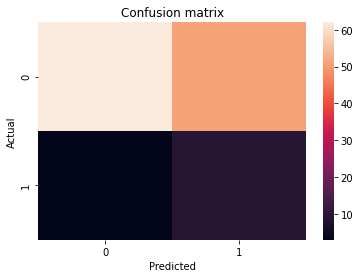

In [49]:

test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

Calculates feature importance

In [50]:
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.014389
1,hour,0.453469
2,date,0.176664
3,device_make,0.355477
4,platform_os,0.000000


Eventhough the'experiment' feature is greater than zero it is not not important for awareness in the Decision Tree Model. The most important feature for awareness in the  Decision Tree Model is hour which has feature importance of 0.45 followed by device_make of 0.33. But this is a result of a decision tree model with max-depth of 4. if we increase the max-depth, we might observe a differnt result in feature importance. But platform_os has no effect at all for awareness in the Desicion Tree model.

### Visualzing feature importance for platform os data

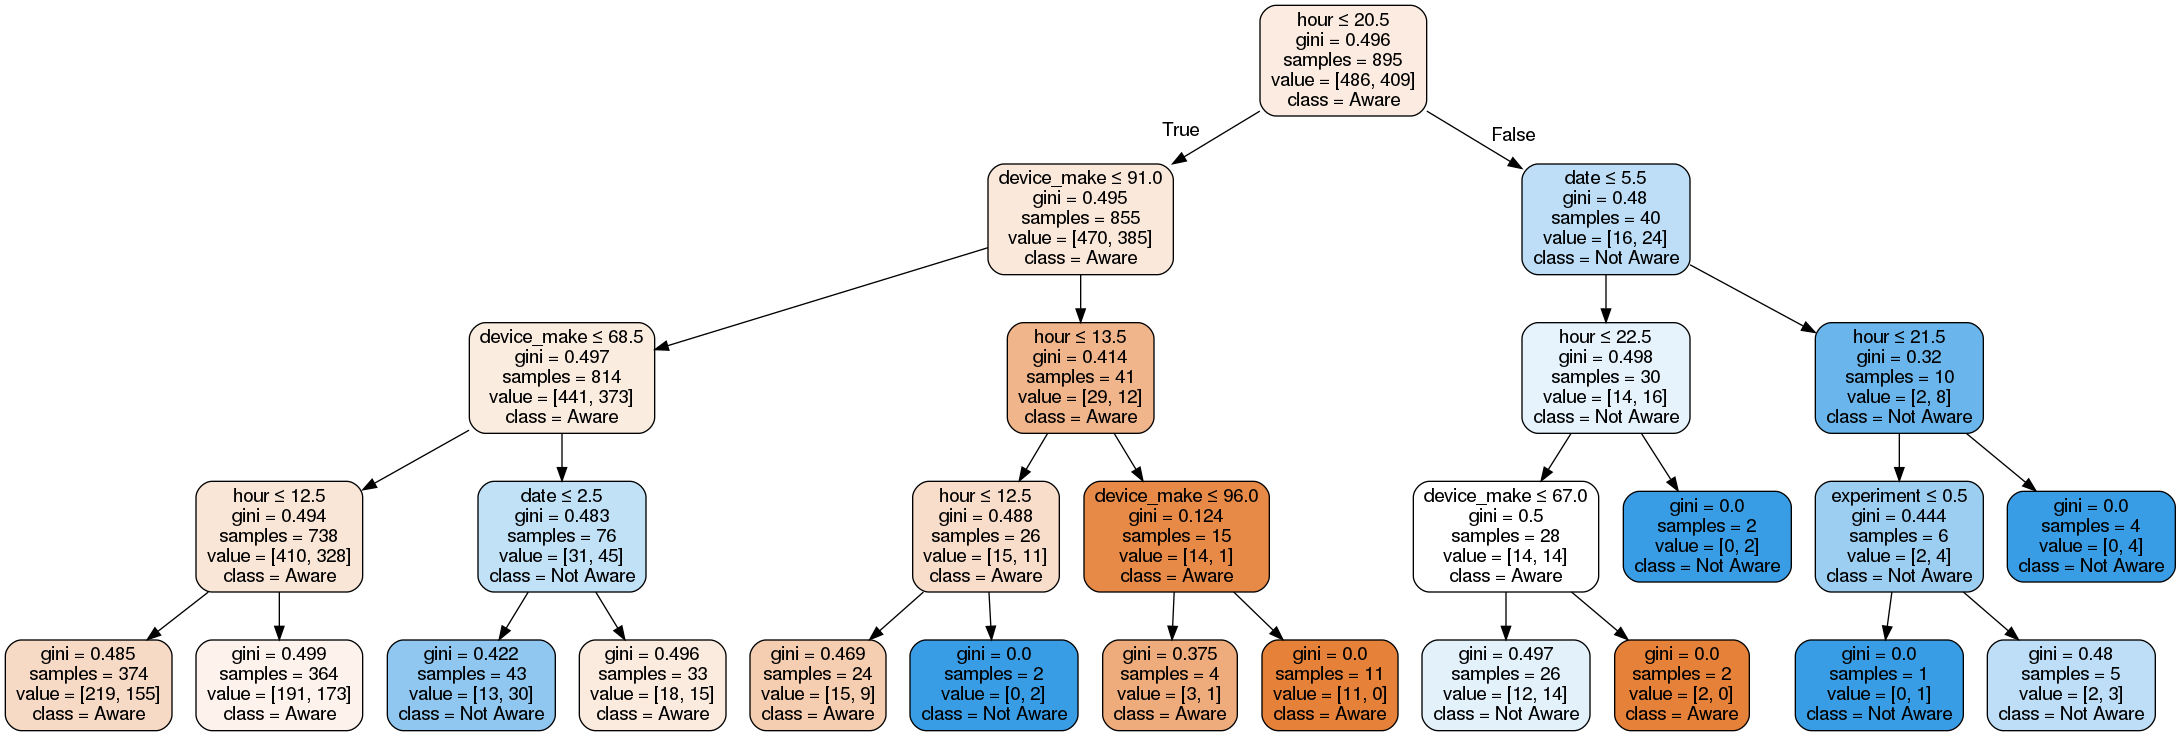

In [53]:
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')
Image(graph.create_png())


<h2>Here also in the platform_os data the experiment feature is found on the 4th level depth of the Decision Tree. From this we can conclude that the'experiment' feature is not the important factor for the target variable.But the most important feature to contribute for awareness of AD in DEsision Tree model is hour which is the root node.<h2>

<h2> Model Building using Logestic Regression <h2>

In [75]:
class LogesticRegressionModel:
    
    def __init__(self, X_train, X_test, y_train, y_test, model_name="LR"):
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model_name = model_name
        
        self.clf = LogisticRegression()
        
    def train(self, folds=1):
        
        kf = KFold(n_splits = folds)
        
        iterator = kf.split(self.X_train)
        
        loss_arr = []
        acc_arr = []
        model_name= self.model_name
        mlflow.end_run()
        for i in range(folds):

            train_index, valid_index = next(iterator)

            X_train, y_train = self.X_train.iloc[train_index], self.y_train.iloc[train_index]
            X_valid, y_valid = self.X_train.iloc[valid_index], self.y_train.iloc[valid_index]

            self.clf = self.clf.fit(X_train, y_train)

            vali_pred = self.clf.predict(X_valid)

            accuracy = self.calculate_score(y_valid, vali_pred)
            loss = loss_function(y_valid, vali_pred)

            self.__printAccuracy(accuracy, i, label="Validation")
            self.__printLoss(loss, i, label="Validation")
            print()

            acc_arr.append(accuracy)
            loss_arr.append(loss)
            
        return self.clf, acc_arr, loss_arr
    
    def test(self):
        y_pred = self.clf.predict(self.X_test)
        
        accuracy = self.calculate_score(self.y_test, y_pred)
        self.__printAccuracy(accuracy, label="Test")
        
        report = self.report(y_pred, self.y_test)
        matrix = self.confusion_matrix(y_pred, self.y_test)
        loss = loss_function(self.y_test, y_pred)
        
        return accuracy, loss, report, matrix 
    
    def __printAccuracy(self, acc, step=1, label=""):
        print(f"step {step}: {label} Accuracy of LogesticRegression is: {acc:.3f}")
    
    def __printLoss(self, loss, step=1, label=""):
        print(f"step {step}: {label} Loss of LogesticRegression is: {loss:.3f}")
    
    def calculate_score(self, pred, actual):
        return metrics.accuracy_score(actual, pred)
    
    def report(self, pred, actual):
        print("Test Metrics")
        print("================")
        print(metrics.classification_report(pred, actual))
        return metrics.classification_report(pred, actual)
    
    def confusion_matrix(self, pred, actual):
        ax=sns.heatmap(pd.DataFrame(metrics.confusion_matrix(pred, actual)))
        plt.title('Confusion matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        return metrics.confusion_matrix(pred, actual)
    
    def get_p_values(self):
        """ 
        Calcualting p_values for logestic regression.
        code refered from the following link
        https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d
        
        """
        denom = (2.0*(1.0+np.cosh(self.clf.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.clf.coef_[0]/sigma_estimates # z-score 
        p_values = [stat.norm.sf(abs(x)) for x in z_scores] ### two tailed test for p-values
        
        p_df = pd.DataFrame()
        p_df['features'] = self.X_train.columns.to_list()
        p_df['p_values'] = p_values
        
        return p_df
    
    def plot_pvalues(self, p_df):
        
        fig, ax = plt.subplots(figsize=(12,7))

        ax.plot([0.05,0.05], [0.05,5])
        sns.scatterplot(data=p_df, y='features', x='p_values', color="green")
        plt.title("P values of features", size=20)

        plt.xticks(np.arange(0,max(p_df['p_values']) + 0.05, 0.05))

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        plt.show()
        return fig

### 2.1 Model training using Logestic Regression using browser dataframe

In [76]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [78]:
logesticRegressionModel = LogesticRegressionModel(X_train, X_test,  y_train, y_test)

folds = 5
clf2, loss_arr_2, acc_arr_2 = logesticRegressionModel.train(folds)

step 0: Validation Accuracy of LogesticRegression is: 0.545
step 0: Validation Loss of LogesticRegression is: 0.675

step 1: Validation Accuracy of LogesticRegression is: 0.527
step 1: Validation Loss of LogesticRegression is: 0.688

step 2: Validation Accuracy of LogesticRegression is: 0.554
step 2: Validation Loss of LogesticRegression is: 0.668

step 3: Validation Accuracy of LogesticRegression is: 0.543
step 3: Validation Loss of LogesticRegression is: 0.676

step 4: Validation Accuracy of LogesticRegression is: 0.574
step 4: Validation Loss of LogesticRegression is: 0.653



Evaluating our model

step 1: Test Accuracy of LogesticRegression is: 0.552
Test Metrics
              precision    recall  f1-score   support

           0       0.89      0.54      0.67       107
           1       0.18      0.61      0.28        18

    accuracy                           0.55       125
   macro avg       0.54      0.58      0.48       125
weighted avg       0.79      0.55      0.62       125



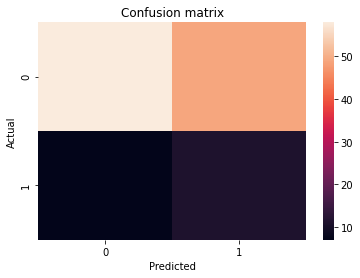

In [79]:
test_acc2, test_loss2, report2, matrix2  = logesticRegressionModel.test()

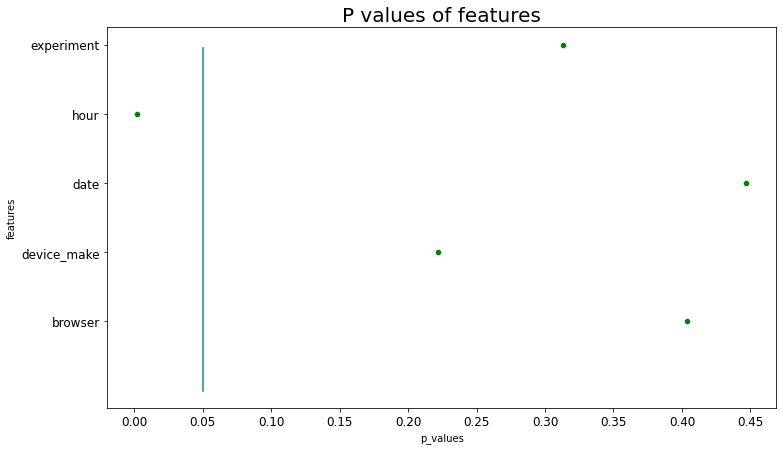

,features,p_values
0,experiment,0.313093
1,hour,0.002316
2,date,0.446756
3,device_make,0.221776
4,browser,0.403688


In [85]:
# plotting p values
p_values_df = logesticRegressionModel.get_p_values()
p_value_fig = logesticRegressionModel.plot_pvalues(p_values_df)
p_values_df

since the p_value of 'experiment' feature is greater than 0.05 here also the'experiment' feature is not  important for awareness in the Logistic Regression Model. The most important feature for awareness in the  Logistic Regression Model is hour which has p_value of 0.0023 which is less than 0.05.

### 2.2 Model training using Logistic Regression for platfrom dataframe


In [86]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platform_df[feature_cols]
y = platform_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [87]:
logesticRegressionModel = LogesticRegressionModel(X_train, X_test,  y_train, y_test)

clf2, loss_arr_2, acc_arr_2 = logesticRegressionModel.train(5)

step 0: Validation Accuracy of LogesticRegression is: 0.518
step 0: Validation Loss of LogesticRegression is: 0.694

step 1: Validation Accuracy of LogesticRegression is: 0.500
step 1: Validation Loss of LogesticRegression is: 0.707

step 2: Validation Accuracy of LogesticRegression is: 0.558
step 2: Validation Loss of LogesticRegression is: 0.665

step 3: Validation Accuracy of LogesticRegression is: 0.534
step 3: Validation Loss of LogesticRegression is: 0.683

step 4: Validation Accuracy of LogesticRegression is: 0.552
step 4: Validation Loss of LogesticRegression is: 0.670



step 1: Test Accuracy of LogesticRegression is: 0.528
Test Metrics
              precision    recall  f1-score   support

           0       0.91      0.53      0.67       112
           1       0.12      0.54      0.19        13

    accuracy                           0.53       125
   macro avg       0.51      0.53      0.43       125
weighted avg       0.83      0.53      0.62       125



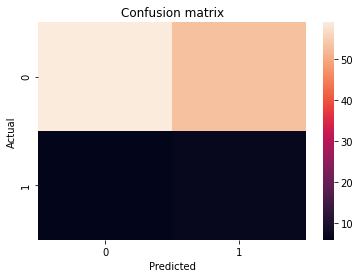

In [88]:
test_acc2, test_loss2, report2, matrix2  = logesticRegressionModel.test()

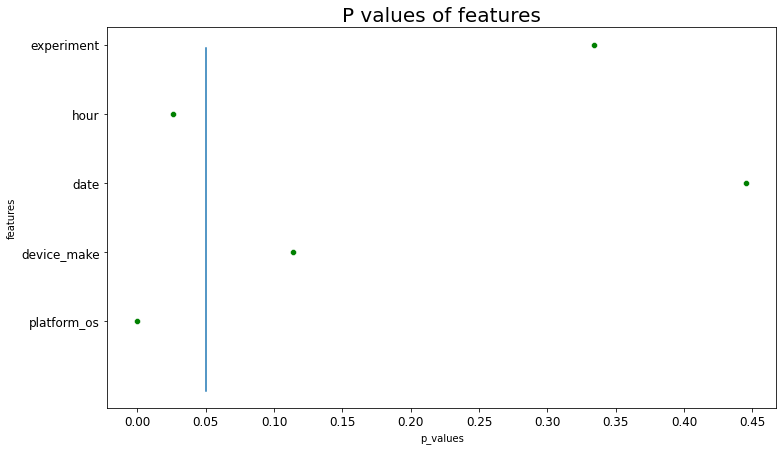

,features,p_values
0,experiment,0.334083
1,hour,0.026379
2,date,0.445275
3,device_make,0.113773
4,platform_os,0.000000


In [89]:
p_values_df = logesticRegressionModel.get_p_values()
fig = logesticRegressionModel.plot_pvalues(p_values_df)
p_values_df

Here also the p_value of 'experiment' feature is greater than 0.05 here also the'experiment' feature is not  important for awareness in the Logistic Regression Model. The most important feature for awareness in the  Logistic Regression Model is hour which has p_value of 0.0023 which is less than 0.05.